#Prediction Eye Diameters from Ultrasound Images using CNN
#### By Matthew Sullivan

### Problem Statement
Recent year have shown the success of convolutional neural networks (CNNs) in diagnosing medical pathologies. One open problem is identifying medical pathologies from ultrasound images, which are sensitive to blood flow and tissues otherwise not visable.

As such, the goal is to predict the horizontal and vertical diameters of an eyeball from ultrasound images. These measurement often require manual labeling, which is costly.

##### Data Curation
We had an ophthalmologist from Brazil in my deep learning course. He was interested in this idea and offered the data.

<figure>
<img src="labeled_eyeball.png" style="width:100%">
    <figcaption align = "center"> <b>Figure 1:</b> A standard eyeball is oval shaped, resulting in two diameters -- a horizontal diameter (red) and vertical diameter (green). The estimated circumference can be seen in orange. </figcaption>
</figure>

##### Import Statements

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import seaborn as sns

Mounted at /content/drive


#### Exploratory Data Analysis
The data has already been split into training and test sets with 80 training samples and 20 test samples. Each sample is $(4 \times 1000 \times 1000)$ in size. Only the first three channels have information in them. The fourth channel contains only the maximum value, 255.

We have a very sparse training and test set to work with. It will be difficult to generalize appropriately.

There does not seem to be many outliers, shown in the box plot.

(80, 4, 1000, 1000)


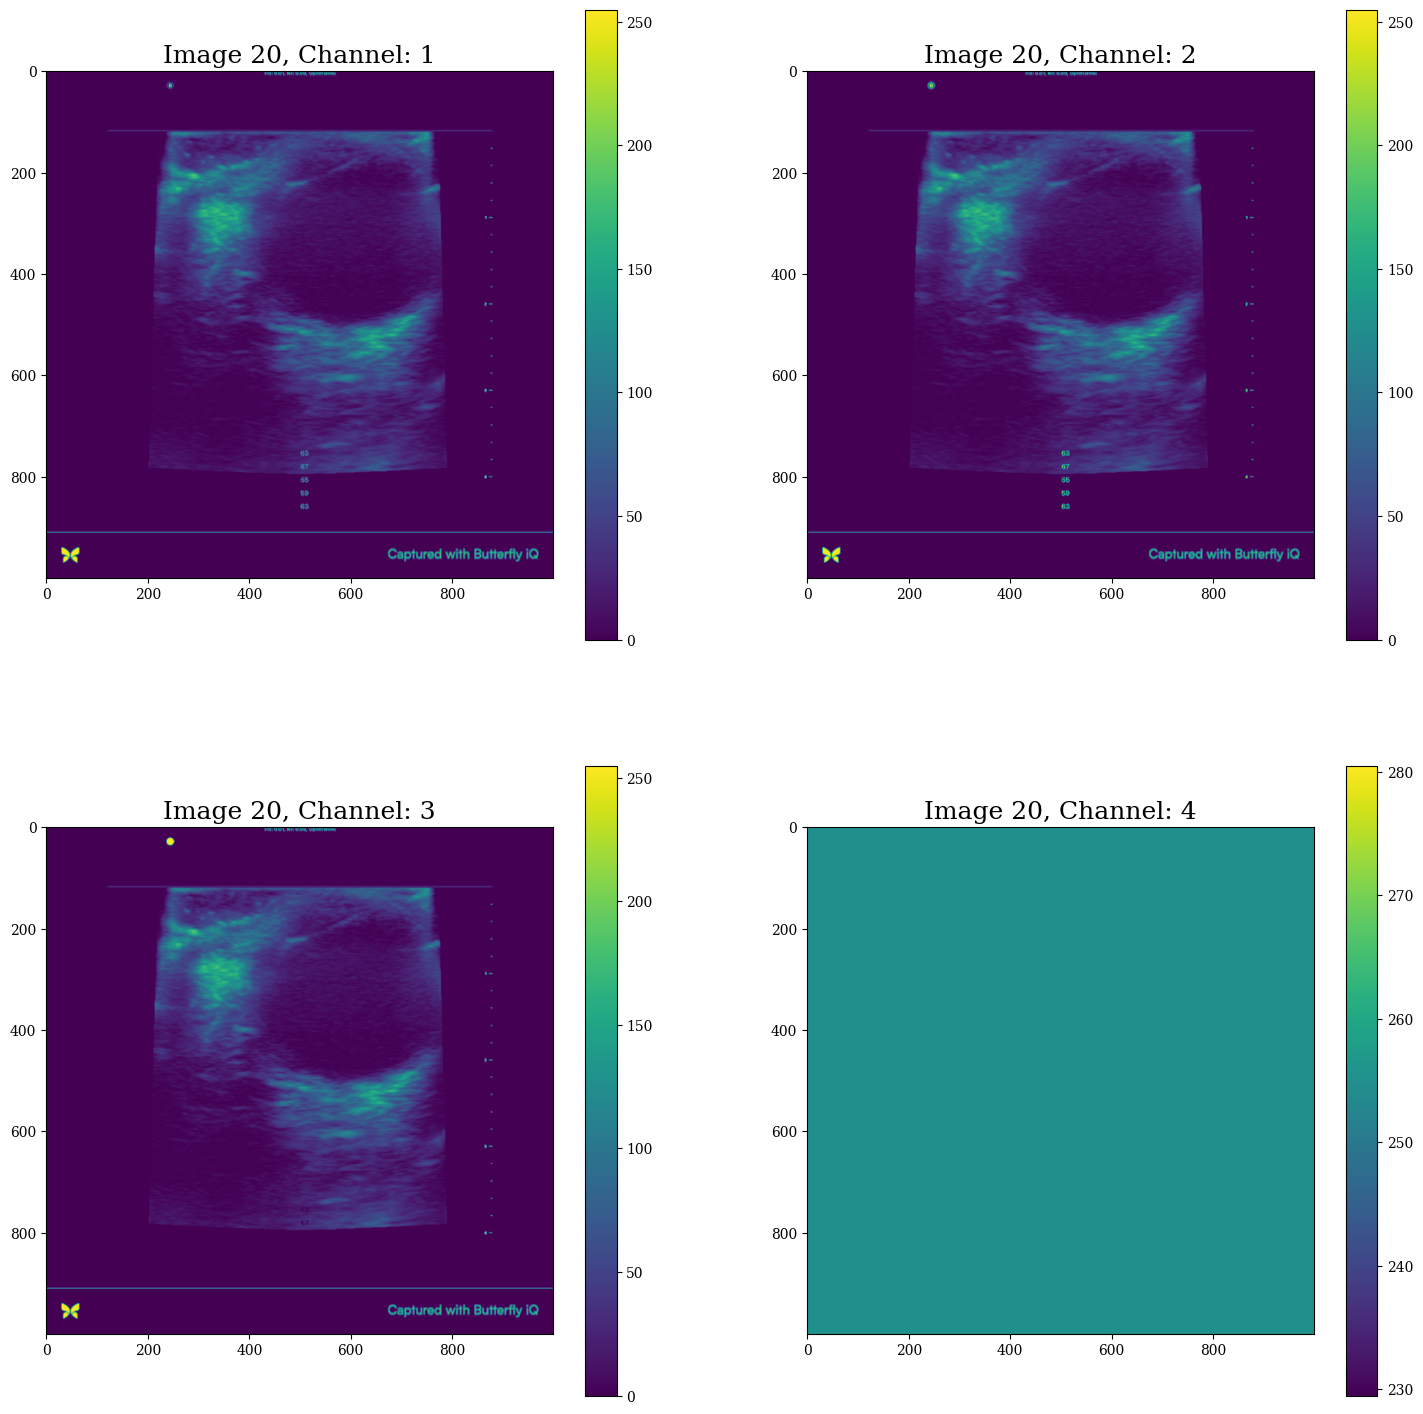

In [95]:
file = h5py.File("/content/drive/MyDrive/Colab Notebooks/mp03files/US_train.h5", "r+")
X_train = np.array(file["/images"])
y_train = np.array(file["/meta"])
file.close()

idx = 20
im = X_train[idx, :, :, :]

fs = 18
plt.figure(figsize=(18, 18))
for ii in range(X_train.shape[1]):
    plt.subplot(2,2,ii+1)
    plt.title("Image "+ str(idx) + ', Channel: ' + str(ii+1), fontsize=fs)
    plt.imshow(im[ii])
    plt.colorbar()

print(X_train.shape)

([<matplotlib.axis.XTick at 0x7952b2210d30>,
 [Text(1, 0, 'Vertical Diameters'), Text(2, 0, 'Horizontal Diameters')])

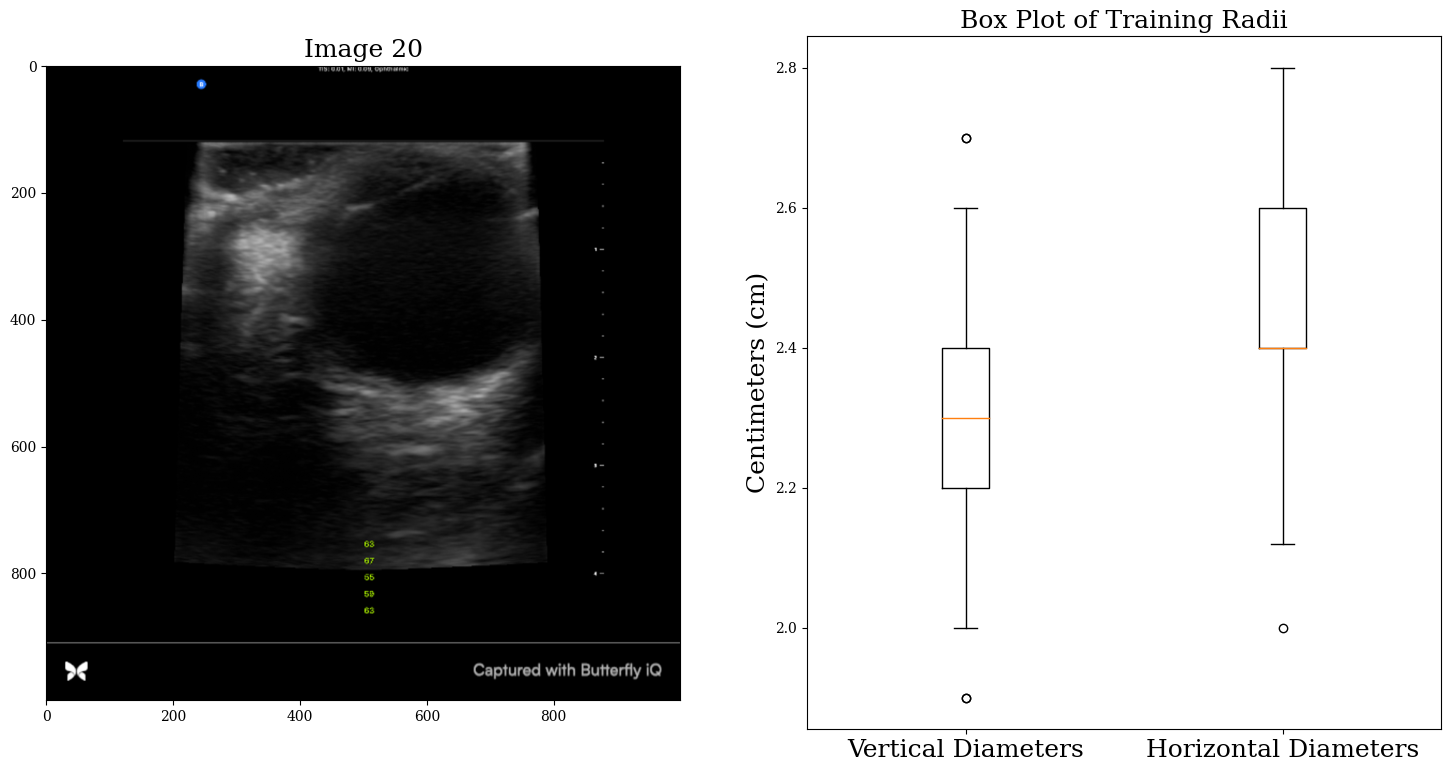

In [96]:
# display an arbitrary image
fs = 18
plt.figure(figsize=(18, 9))
plt.subplot(1,2,1)
plt.title("Image "+ str(idx), fontsize=fs)
plt.imshow(np.moveaxis(im, 0, -1) / im.max())

plt.subplot(1,2,2)
plt.title("Box Plot of Training Radii", fontsize=fs)
plt.ylabel("Centimeters (cm)", fontsize=fs)
_ = plt.boxplot(y_train)
plt.xticks(ticks=[1,2], labels=['Vertical Diameters', 'Horizontal Diameters'], fontsize=fs)

#### Data Augmentation
Previous research showed that histogram equalization on grayscale images significantly improve the performances of CNNs (Wang, J. and Lee, S, "Data Augmentation Methods Applying Grayscale Images for Convolutional Neural Networks in Machine Vision").

In addition, it is field knowledge that one can synthetically generate more images by rotating, flipping, and zooming their current data set. I will be flipping horizontally and vertically.

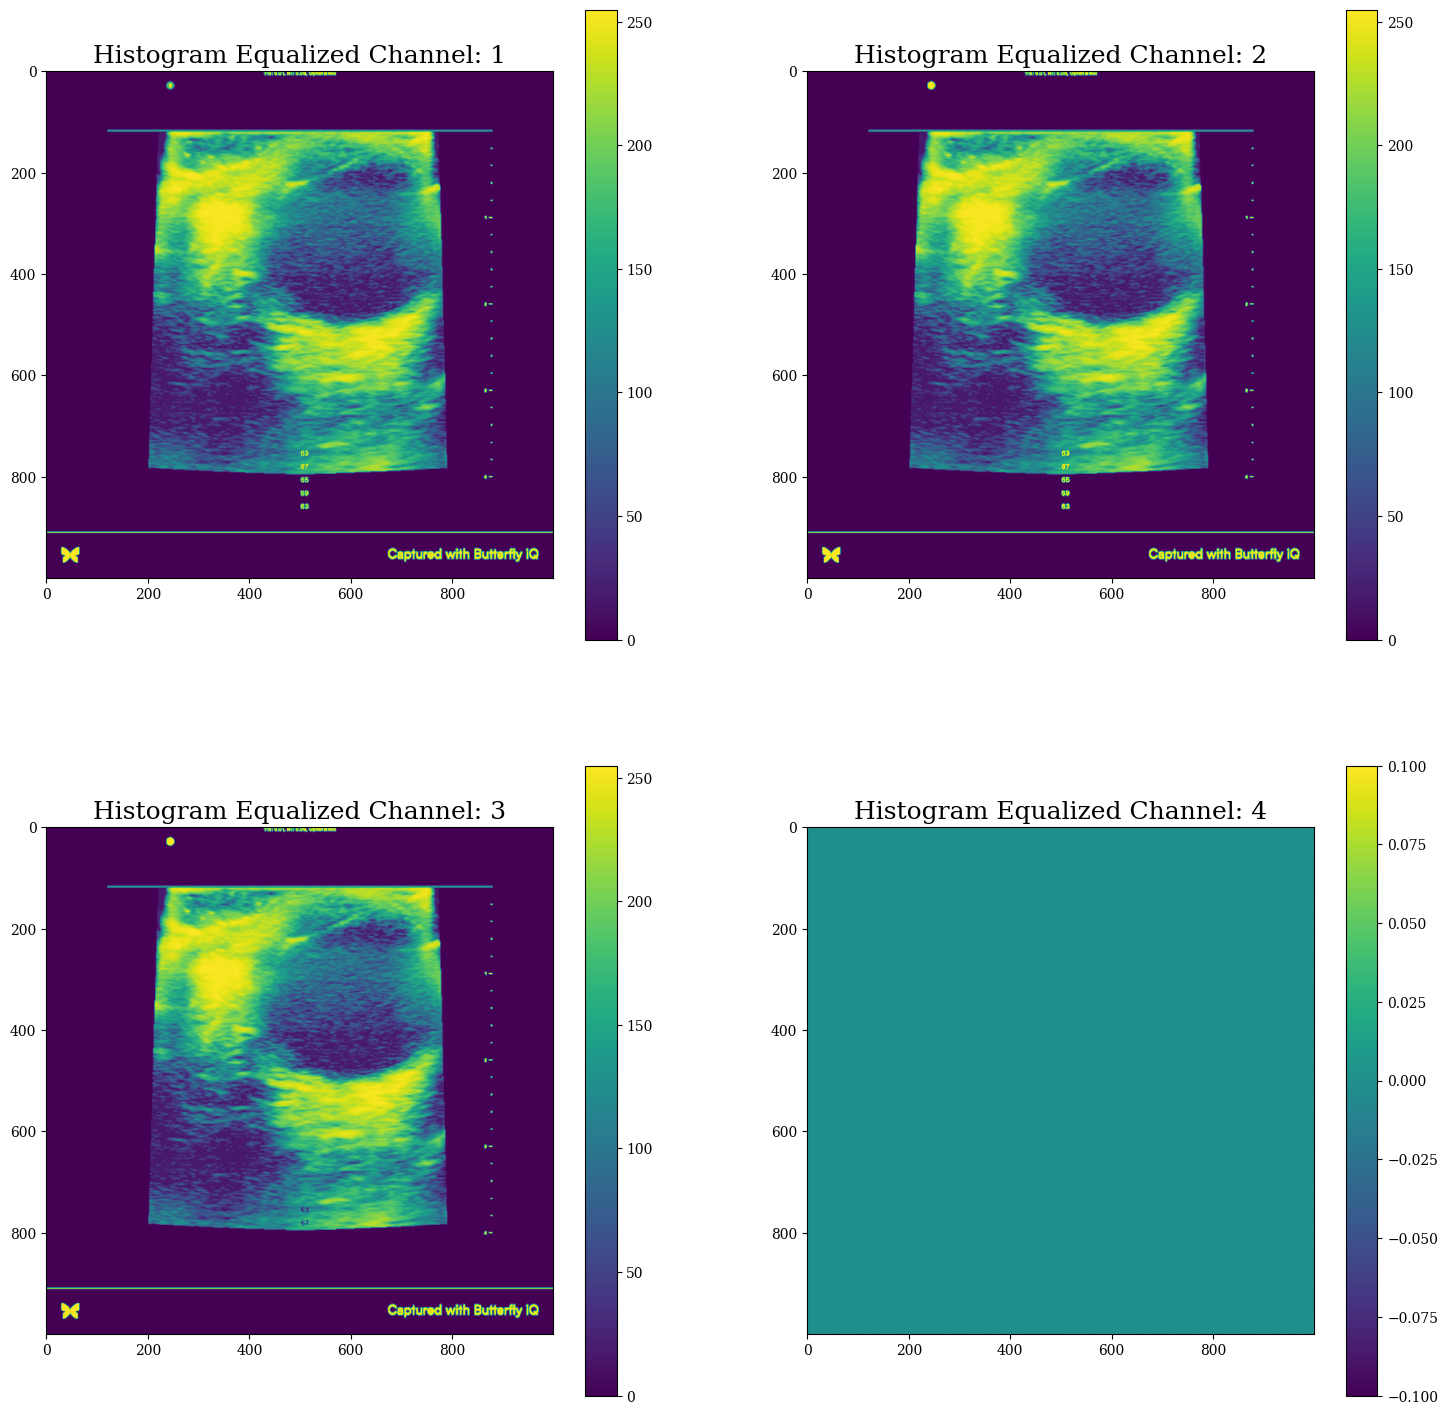

In [97]:
def equalizeHist(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    return cdf[img.astype(int)]

idx = 20
im = X_train[idx, :, :, :]

plt.figure(figsize=(18,18))
for ii in range(X_train.shape[1]):
    im[ii] = equalizeHist(im[ii])
    plt.subplot(2,2,ii+1)
    plt.title("Histogram Equalized Channel: " + str(ii+1), fontsize=fs)
    plt.imshow(im[ii])
    plt.colorbar()

### Neural Network Design and Training

I decided to implement a network-in-network neural network (Lin, M. and Chen, Q. and Yan, S., "Network in Network"). We could have two separate neural networks, one to estimate each diameter. However, previous research point towards more success in constructing two separate networks sharing one input and loss function. We are able to leverage solving one loss function that is correlated to both networks.

Other neural network applications found success using Optuna -- a hyperparameter optimization framework to automate neural network parameter design. This occurred outside of this notebook as it often takes hour of pruning faulty network and restarting training. The resulting network design come from the results.  


##### Data Loader
The training data is loaded and histogram equalized. A standard 80/20 split was used to form training (64 images) and validation (16 images) sets.

In [26]:
def equalizeHist(img):
    img = img.astype(int)
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    img2 = cdf[img]
    return img2

class getDataset(Dataset):
    def __init__(self):

        file = h5py.File("/content/drive/MyDrive/Colab Notebooks/mp03files/US_train.h5", "r+")
        X = np.array(file["/images"])
        y = np.array(file["/meta"])
        file.close()

        N, C, _, _ = X.shape
        X_flip = X.copy()
        for ii in range(N):
            flip = np.random.randint(0, 3)
            for cc in range(C):
                X[ii,cc] = equalizeHist(X[ii,cc])

        self.X = X
        self.y = y
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(X, y, test_size=0.2)

        N, C, _, _ = self.x_train.shape
        X_flip = self.x_train.copy()
        for ii in range(N):
            flip = np.random.randint(0, 3)
            for cc in range(C):
                if flip == 0:
                    X_flip[ii,cc] = np.fliplr(X_flip[ii,cc])
                elif flip == 1:
                    X_flip[ii,cc] = np.flipud(X_flip[ii,cc])
                else:
                    X_flip[ii,cc] = np.fliplr(np.flipud(X_flip[ii,cc]))

        self.x_train = np.concatenate([self.x_train, X_flip])
        self.y_train = np.concatenate([self.y_train, self.y_train])

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

    def getValidation(self):
        return self.x_val, self.y_val

    def getAll(self):
        return self.X, self.y

#### Train and Validation
Training and validation functions that utilizing a GPU if available

In [3]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    if torch.cuda.is_available():
      device = torch.device("cuda")
    else:
      device = torch.device("cpu")
    train_running_loss = 0.0
    model.to(device)
    for i, data in enumerate(trainloader):
        image, labels = data
        image = image.to(device).to(torch.float32)
        labels = labels.to(device).to(torch.float32)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / (i+1)
    return epoch_loss

def validate(model, dataset, criterion):
    x_val, y_val = dataset.getValidation()
    image = torch.tensor(x_val).to(torch.float32)
    labels = torch.tensor(y_val)
    model.eval()
    if torch.cuda.is_available():
      device = torch.device("cuda")
    else:
      device = torch.device("cpu")
    # print('Validation')
    valid_running_loss = 0.0
    counter = 0
    with torch.no_grad():
        counter += 1
        image = image.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        valid_running_loss += loss.item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    return epoch_loss

##### Network Architecture

In [4]:
class NetworkInNetwork(nn.Module):
    def __init__(self):
        super(NetworkInNetwork, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 6, kernel_size=(32, 32)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6, 4, kernel_size=(16, 16)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(4, 4, kernel_size=(16, 16)),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 6, kernel_size=(32, 32)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6, 4, kernel_size=(16, 16)),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(4, 4, kernel_size=(16, 16)),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.linear1 = nn.Sequential(
            nn.Linear(47524, 120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 1)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(47524, 120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 1)
        )

        self.flatten = nn.Flatten()

    def forward(self, x):
        # you can see the Network-In-Network (NiN) design here
        # one input is split into two "different" and independent networks
        radius1 = self.conv1(x)
        radius2 = self.conv2(x)

        radius1 = self.flatten(radius1)
        radius2 = self.flatten(radius2)

        radius1 = self.linear1(radius1)
        radius2 = self.linear2(radius2)

        output = torch.concat([radius1, radius2], dim=1)
        return output

##### Training Specifications

The main debate was between mean square error (MSE) loss or mean absolute error (MAE). I decided on mean squared error as we care significantly about the outliers, even if we have a sparse amount of data.

The batch size was set to 8 without much reasoning. Previous research showed shuffling the training data can help promote convergence. The ADAM optimizer performed better than SGD, which is to be expected.


In [27]:
batch_size = 8
dataset = getDataset()
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

train_loss, valid_loss = [], []
epochs = 14

model = NetworkInNetwork()
criterion = nn.MSELoss(reduction='mean') # (0.14, 0.1)
# criterion = nn.MSELoss() #
# criterion = nn.L1Loss() #
# optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# start the training
for epoch in range(epochs):
    # print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, trainloader, optimizer, criterion)
    valid_epoch_loss = validate(model, dataset, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    if epoch % 5 == 0:
        print(f"Training loss: {train_epoch_loss:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}")
        print('-'*50)
print('TRAINING COMPLETE')

## saves model weights
# torch.save(model.state_dict(), 'MSELoss_14epoch_Adam_model.pt')

Training loss: 3.593
Validation loss: 2.679
--------------------------------------------------
Training loss: 0.255
Validation loss: 0.106
--------------------------------------------------
Training loss: 0.164
Validation loss: 0.095
--------------------------------------------------
TRAINING COMPLETE


0.10910395991740274
0.14576645358465612


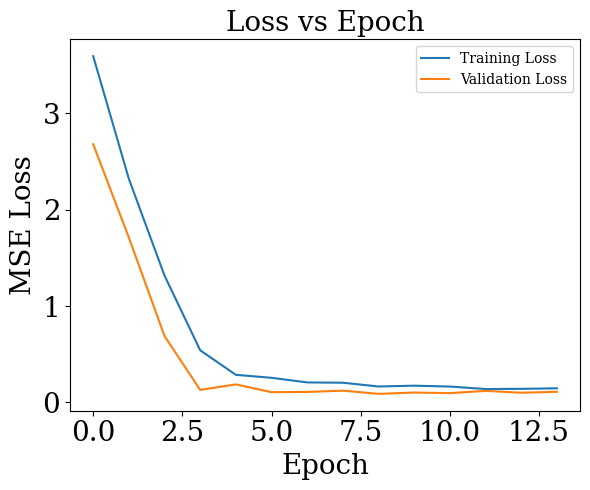

In [99]:
xlabel = 'Epoch'
ylabel = 'MSE Loss'
title  = 'Loss vs Epoch'
fname = 'LossIteration'

plt.rc('font', family='serif')
plt.rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.title(title, fontsize=20)
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
ax.set_xlabel(xlabel, fontsize=20)
ax.set_ylabel(ylabel, fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.legend()
print(valid_loss[-1])
print(train_loss[-1])
# plt.savefig(fname + '.pdf')

In [100]:
## loading model params so I don't need to re-run

model = NetworkInNetwork()
model.load_state_dict(torch.load('MSELoss_14epoch_Adam_model.pt'))

<All keys matched successfully>

#### Model Assessment

Most of the validation set has an MSE error around 0.15 cm. One image, however, performs much worse than the others.

Visualizing the outlier image shows that the eye socket isn't as continuous as we might expect. There appears to be a straight line slicing the top of the socket off. Furthermore, the horizontal edges are blurred into the socket as well.

Even I am struggling to assess where the outline of the socket actually is. It's hard to tell if something is in front of the socket or if it's unusually shaped.

In [101]:
loss, outputs = validate(model, dataset, criterion)
outputs = outputs.cpu().detach().numpy()

[0.87806983 0.66213064]


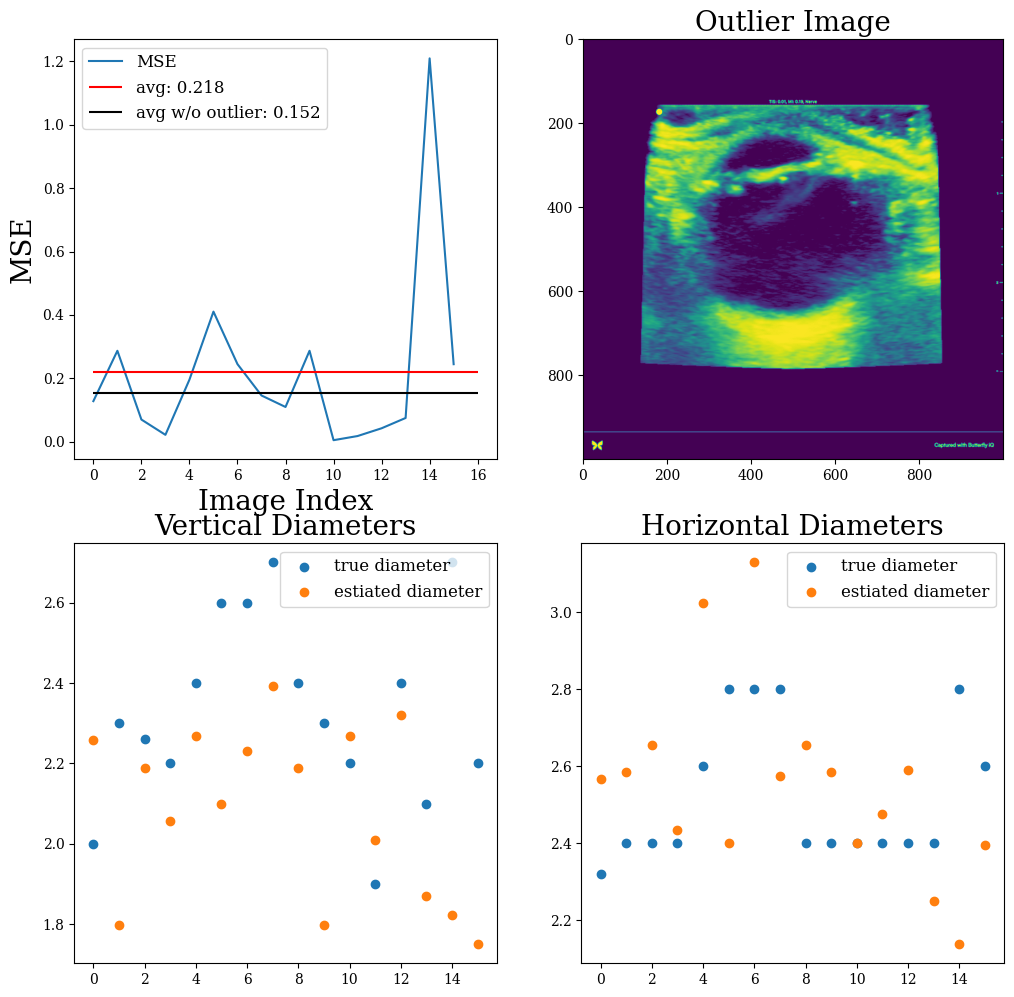

In [108]:
x_val, y_val = dataset.getValidation()
error = np.sum(np.power(y_val - outputs, 2), 1)

avg = np.mean(error)
avg_noOutlier = np.mean(np.delete(error, 14))

t = np.arange(0, len(y_val), 1)

fs = 20
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.ylabel("MSE", fontsize=fs)
plt.xlabel("Image Index", fontsize=fs)
plt.plot(error, label='MSE')
plt.hlines(avg, 0, len(y_val), color='r', label='avg: '+str(avg)[:5])
plt.hlines(avg_noOutlier, 0, len(y_val), color='k', label='avg w/o outlier: '+str(avg_noOutlier)[:5])
plt.legend(fontsize=12)

im = x_val[14,2]
plt.subplot(2,2,2)
plt.title("Outlier Image", fontsize=fs)
plt.imshow(im)

plt.subplot(2,2,3)
plt.title("Vertical Diameters", fontsize=fs)
plt.scatter(t, y_val[:,0], label='true diameter')
plt.scatter(t, outputs[:,0], label='estiated diameter')
plt.legend(fontsize=12)


plt.subplot(2,2,4)
plt.title("Horizontal Diameters", fontsize=fs)
plt.scatter(t, y_val[:,1], label='true diameter')
plt.scatter(t, outputs[:,1], label='estiated diameter')
plt.legend(fontsize=12)
print(abs(outputs-y_val)[14])

### Model Analysis (Current Progress)
To help see what the CNN is doing, we can visualize guided backpropagation, which I will be doing for a low error image and the erroneous outlier image.

Between the two images, the lower error one is more encapsulated. The high error image has very diffused boundaries.

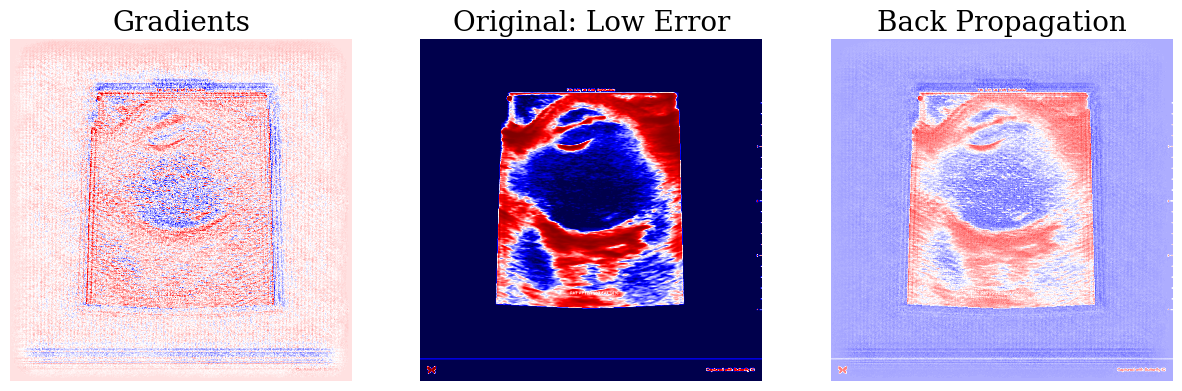

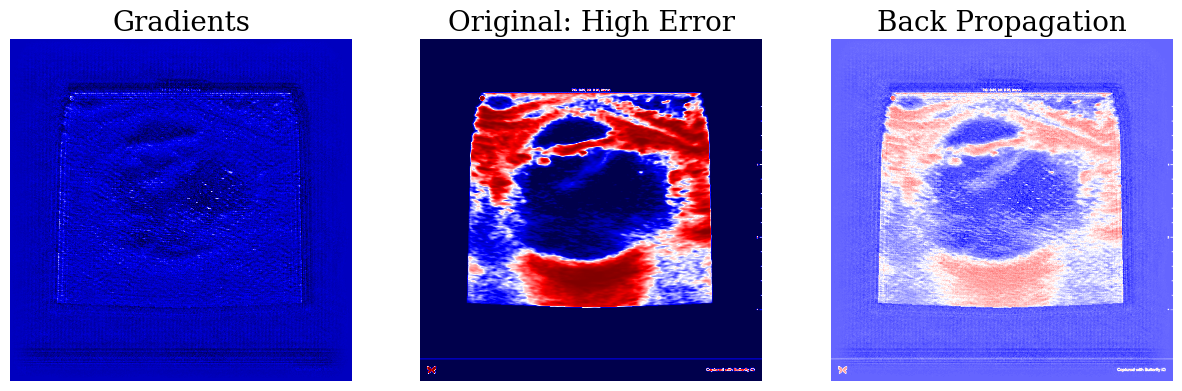

In [148]:
def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

def plot_maps(title, img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.title("Gradients", fontsize=20)
    plt.imshow(img1, vmin=vmin, vmax=vmax, cmap="seismic")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.title("Original: " + title, fontsize=20)
    plt.imshow(img2, cmap = "seismic")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.title("Back Propagation", fontsize=20)
    plt.imshow(img1*mix_val+img2/mix_val, cmap='seismic')
    plt.axis("off")


def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

def prep_output(img_tensor):
    invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                    std = [ 1., 1., 1. ]),
                            ])
    out = invTrans(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out

for i, module in enumerate(model.modules()):
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_hook_function)

ind = 2
img = x_val[ind]
labels = y_val[ind]
img = np.expand_dims(img, axis=0)
input_img = torch.tensor(img).to(torch.float32)
input_img.requires_grad = True
# forward/inference
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

out = model(input_img.to(device))

A = 1
B = 4
out = model(input_img.to(device))
out[0,0].backward()
grads = input_img.grad
plot_maps('Low Error', norm_flat_image(grads[0,A:B][None,:]), norm_flat_image(input_img[0,A:B][None,:]) )



img = x_val[14,:,:,:]
img = np.expand_dims(img, axis=0)
input_img = torch.tensor(img).to(torch.float32)
input_img.requires_grad = True

A = 1
B = 4
out = model(input_img.to(device))
out[0,0].backward()
grads = input_img.grad

plot_maps('High Error', norm_flat_image(grads[0,A:B][None,:]), norm_flat_image(input_img[0,A:B][None,:]) )